In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
import torchsummary
from torchvision import transforms, models
import time
from sklearn.metrics import classification_report

In [3]:
label_data=np.loadtxt('/home/sumins/workspace/washout classification/min_slice/label_train.txt',dtype=int)
label_data=label_data.tolist()
label_datat=np.loadtxt('/home/sumins/workspace/washout classification/min_slice/label_test.txt',dtype=int)
label_datat=label_datat.tolist()

In [4]:
data_path='/home/sumins/workspace/washout classification/min_slice/channel4_train.nii'
channel4=[]
total=nib.load(data_path).get_fdata()
totalslice=total.shape[0]  

for i in range(0,totalslice):
    channel4.append(total[i,:,:,:])


data_patht='/home/sumins/workspace/washout classification/min_slice/channel4_test.nii'
channel4t=[]
totalt=nib.load(data_patht).get_fdata()
totalslicet=totalt.shape[0]  

for i in range(0,totalslicet):
    channel4t.append(totalt[i,:,:,:])

In [5]:
WINDOW_MAX = 200
WINDOW_MIN = 0
GLOBAL_PIXEL_MEAN = 0.1

class CustomDataset(Dataset): 
  def __init__(self,volume_list,all_labels,transforms=None):
    self.volume_list=volume_list
    self.all_labels=all_labels
    self.length=len(all_labels)
    self.transforms=transforms


  def __len__(self):
    return self.length


  def __getitem__(self, idx):
    npy=self.volume_list[idx]

    npy[npy > WINDOW_MAX] = WINDOW_MAX
    npy[npy < WINDOW_MIN] = WINDOW_MIN
    
    npy = (npy - WINDOW_MIN) / (WINDOW_MAX - WINDOW_MIN)
    npy -= GLOBAL_PIXEL_MEAN
    npy=npy.astype(dtype='float32')
    
    if self.transforms is not None:
      npy=self.transforms(npy)
    
    return{'npy':npy,'label':self.all_labels[idx]}

In [6]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
resnet18_pretrained=models.resnet50(pretrained=True)
print(resnet18_pretrained)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
class LiverResnet(nn.Module):
    def __init__(self,in_channels=4):
        super(LiverResnet,self).__init__()
        
        #torchvision.models에서 사전훈련된 resnet모델 가져오기
        self.model=models.resnet50(pretrained=True)
        
        #기본채널이 3이기 때문에 liver data set에 맞게 1로 바꿔줌
        #원래 resnet의 첫번째 layer
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.conv1=nn.Conv2d(in_channels,64,kernel_size=7,stride=2,padding=3,bias=False)
        
        #class수 변경
        num_ftrs=self.model.fc.in_features
        self.model.fc=nn.Linear(num_ftrs,2)

    def forward(self,x):
            return self.model(x)
        
        

In [8]:
transforms_train = transforms.Compose([transforms.ToTensor()
                                       ])
transforms_test = transforms.Compose([transforms.ToTensor()
                                       ])

hyper_param_epoch=50
hyper_param_batch=4
hyper_param_learning_rate=0.0001

In [9]:
train_dataset=CustomDataset(volume_list=channel4, all_labels=label_data,transforms=transforms_train)
train_loader = DataLoader(train_dataset, batch_size=hyper_param_batch, shuffle=True)
test_dataset=CustomDataset(volume_list=channel4t, all_labels=label_datat,transforms=transforms_train)
test_loader = DataLoader(test_dataset, batch_size=hyper_param_batch, shuffle=True)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device,"/" ,torch.cuda.device_count())

custom_model=LiverResnet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=hyper_param_learning_rate)

cuda:0 / 1


In [11]:
def validation_loss(model):
    total_loss=0
    for i_batch, item in enumerate(test_loader):
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        if(len(labels)!=hyper_param_batch):
            break
        outputs =model(npys)
        loss = criterion(outputs, labels)

        total_loss+=loss.item()
    return total_loss/(i_batch+1)

In [ ]:
loss_value=1
start=time.time()
custom_model.train()
train_loss_history=[]
valid_loss_history=[]
for e in range(hyper_param_epoch):
        for i_batch, item in enumerate(train_loader):
                npys = item['npy'].to(device)
                labels = item['label'].to(device)
                if(len(labels)!=hyper_param_batch):
                        break
                #print(npys)
                # Forward pass
                outputs =custom_model(npys)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        val_loss=validation_loss(custom_model)
        train_loss_history.append(loss.item())
        valid_loss_history.append(val_loss)
        print('Epoch [{}/{}],i_batch={} ,Train_Loss: {:.4f},Valid_loss: {:.4f}'
                                        .format(e + 1, hyper_param_epoch, i_batch+1, loss.item(),val_loss))
        print("Time: {}sec".format(time.time()-start))
        start=time.time()
        if loss_value>val_loss:
                loss_value=val_loss
                torch.save({
                'epoch': e,
                'model_state_dict': custom_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, '/home/sumins/workspace/washout classification/model_save/min_resnet50.pth')


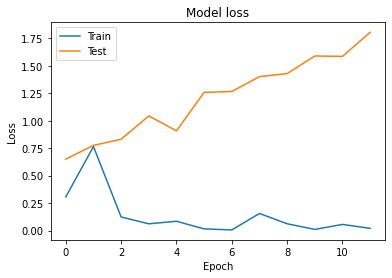

In [ ]:
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
import csv


with open("valid_loss_history_resnet18.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(valid_loss_history)


In [ ]:
import csv


with open("train_loss_history_resnet18.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(train_loss_history)


In [12]:
true_label=[]
pred_label=[]

model=LiverResnet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)

checkpoint = torch.load('//home/sumins/workspace/washout classification/model_save/min_resnet50.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(loss)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for item in test_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        
        outputs =model(npys)
        _, predicted = torch.max(outputs.data, 1)
        true_label.extend(labels)
        pred_label.extend(predicted)
        total += len(labels)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

tensor(0.3187, device='cuda:0', requires_grad=True)
Test Accuracy of the model on the 363 test images: 68.04407713498622 %


: 

In [ ]:
true_labels=torch.tensor(true_label)
true_labels=true_labels.tolist()
pred_labels=torch.tensor(pred_label)
pred_labels=pred_labels.tolist()
print(classification_report(true_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       103
           1       0.72      1.00      0.83       260

    accuracy                           0.72       363
   macro avg       0.36      0.50      0.42       363
weighted avg       0.51      0.72      0.60       363



/home/sumins/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sumins/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sumins/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
true_label1=[]
pred_label1=[]

model=LiverResnet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)

checkpoint = torch.load('/home/sumins/workspace/model_check/model_alexnet.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(loss)
custom_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for item in train_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        
        outputs =model(npys)
        _, predicted = torch.max(outputs.data, 1)
        true_label1.extend(labels)
        pred_label1.extend(predicted)
        total += len(labels)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} train images: {} %'.format(total, 100 * correct / total))

tensor(0.7323, device='cuda:0', requires_grad=True)
Test Accuracy of the model on the 19310 train images: 97.1620921802175 %


In [ ]:
true_labels1=torch.tensor(true_label1)
true_labels1=true_labels1.tolist()
pred_labels1=torch.tensor(pred_label1)
pred_labels1=pred_labels1.tolist()
print(classification_report(true_labels1,pred_labels1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13062
           1       1.00      1.00      1.00      6248

    accuracy                           1.00     19310
   macro avg       1.00      1.00      1.00     19310
weighted avg       1.00      1.00      1.00     19310

